---
title: "Module 05: Lab 02"
subtitle: "Regression Modeling on Employment Data"
author:
  - name: Norah Jones
    affiliations:
      - id: cmu
        name: Carnegie Mellon University
        city: Pittsburgh
        state: PA
      - id: chicago
        name: University of Chicago
        city: Chicago
        state: IL
  - name: John Hamm
    affiliations:
      - ref: cmu
      - name: University of California, San Diego
        city: San Diego
        state: CA
number-sections: true
date: "2024-11-21"
format:
  html:
    theme: cerulean
    toc: true
    toc-depth: 2
date-modified: today
date-format: long
execute: 
  echo: false
  eval: false
  freeze: auto
---

# Objectives {.unnumbered}

1. Use **PySpark** to process the Lightcast dataset.
2. Engineer features from structured columns for salary prediction.
3. Train **Linear Regression model**.
4. Evaluate models using **RMSE** and **R²**.
5. Visualize predictions using diagnostic plots.
6. Push work to GitHub and submit the repository link.

# Setup {.unnumbered}

The instruction below provides you with general keywords for columns used in the lightcast file. See the data schema generated after the load dataset code above to use proper column name. For visualizations, tables, or summaries, please **customize colors, fonts, and styles** as appropriate to avoid a **2.5-point deduction**. Also, **provide a two-sentence explanation** describing key insights drawn from each section's code and outputs. 

1. Follow the steps below as necessary, use your best judgement in importing/installing/creating/saving files as needed.
2. Create a new Jupyter Notebook in your `ad688-sp25-lab08` directory named `lab08_yourname.ipynb`, if the file exists make sure to change the name.
3. Use your **EC2 instance** for this lab.
4. Ensure the `lightcast_data.csv` file is available on the EC2 instance. if not then **Download the dataset**
5. **Add the dataset to `.gitignore`** to avoid pushing large files to GitHub. Open your `.gitignore` file and add:
6. Make sure to create a virtual environment and install the required Python libraries if needed, don't forget to activate it:
7. Install the required Python libraries if needed, you can also use the given requirement file to install the packages to the virtual environment:

```bash
python3 -m venv .venv
source .venv/bin/activate
gdown https://drive.google.com/uc?id=1V2GCHGt2dkFGqVBeoUFckU4IhUgk4ocQ
echo "lightcast_job_postings.csv" >> .gitignore
pip install -r requirements.txt
```


# Load the Dataset
1. **Load the Raw Dataset**:
   - Use Pyspark to the `lightcast_data.csv` file into a DataFrame:
   - You can reuse the previous code. 
   - [Copying code from your friend constitutes plagiarism. DO NOT DO THIS]{.uured-bold}.

In [1]:
#| eval: true
#| echo: true
from pyspark.sql import SparkSession
import pandas as pd
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "notebook"

# Initialize Spark Session
spark = SparkSession.builder.appName("LightcastData").getOrCreate()

# Load Data
df = df = spark.read.option("header", "true") \
               .option("inferSchema", "true") \
               .option("multiLine", "true") \
               .option("escape", "\"") \
               .csv("./lightcast_job_postings.csv")

# Show Schema and Sample Data
print("---This is Diagnostic check, No need to print it in the final doc---")

df.printSchema() # comment this line when rendering the submission
df.show(5)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/07 23:22:36 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
                                                                                

---This is Diagnostic check, No need to print it in the final doc---
root
 |-- ID: string (nullable = true)
 |-- LAST_UPDATED_DATE: string (nullable = true)
 |-- LAST_UPDATED_TIMESTAMP: timestamp (nullable = true)
 |-- DUPLICATES: integer (nullable = true)
 |-- POSTED: string (nullable = true)
 |-- EXPIRED: string (nullable = true)
 |-- DURATION: integer (nullable = true)
 |-- SOURCE_TYPES: string (nullable = true)
 |-- SOURCES: string (nullable = true)
 |-- URL: string (nullable = true)
 |-- ACTIVE_URLS: string (nullable = true)
 |-- ACTIVE_SOURCES_INFO: string (nullable = true)
 |-- TITLE_RAW: string (nullable = true)
 |-- BODY: string (nullable = true)
 |-- MODELED_EXPIRED: string (nullable = true)
 |-- MODELED_DURATION: integer (nullable = true)
 |-- COMPANY: integer (nullable = true)
 |-- COMPANY_NAME: string (nullable = true)
 |-- COMPANY_RAW: string (nullable = true)
 |-- COMPANY_IS_STAFFING: boolean (nullable = true)
 |-- EDUCATION_LEVELS: string (nullable = true)
 |-- EDUCATIO

25/04/07 23:22:54 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
                                                                                

+--------------------+-----------------+----------------------+----------+--------+---------+--------+--------------------+--------------------+--------------------+-----------+-------------------+--------------------+--------------------+---------------+----------------+--------+--------------------+-----------+-------------------+----------------+---------------------+-------------+-------------------+-------------+------------------+---------------+--------------------+--------------------+--------------------+-------------+------+-----------+----------------+-------------------+---------+-----------+--------------------+--------------------+-------------+------+--------------+-----+--------------------+-----+----------+---------------+--------------------+---------------+--------------------+------------+--------------------+------------+--------------------+------+--------------------+------+--------------------+------+--------------------+------+--------------------+------+------

# Feature Engineering

Feature Engineering is a crucial step in preparing your data for machine learning. In this lab, we will focus on the following tasks:

1. **Drop rows with missing values** in the target variable and key features.
2. By now you are already familiar with the code and the data. Based on your understanding please choose any 3 (my code output has 10) variables as:
   1. two continuous variables (use your best judgment!)
   2. one categorical.
   3. Your dependent variable (y) is `SALARY`.
3. **Convert categorical variables** into numerical representations using **StringIndexer** and **OneHotEncoder**.
4. **Assemble features** into a single vector using **VectorAssembler**.
5. **Split the data** into training and testing sets.

In [2]:
from pyspark.sql.functions import col
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline

# Drop rows with missing values
df = df.dropna(subset=["SALARY", "MODELED_DURATION", "MIN_YEARS_EXPERIENCE", "EDUCATION_LEVELS_NAME"])

# Define categorical column
categorical_cols = ["EDUCATION_LEVELS_NAME"]
numeric_cols = ["MODELED_DURATION", "MIN_YEARS_EXPERIENCE"]

# Index + OneHot Encode
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_idx", handleInvalid='skip') for col in categorical_cols]
encoders = [OneHotEncoder(inputCol=f"{col}_idx", outputCol=f"{col}_vec") for col in categorical_cols]

# Assemble features
assembler = VectorAssembler(
    inputCols=numeric_cols + [f"{col}_vec" for col in categorical_cols],
    outputCol="features"
)

# Run pipeline
pipeline = Pipeline(stages=indexers + encoders + [assembler])
data = pipeline.fit(df).transform(df)

data.select("SALARY", "features").show(5, truncate=False)

+------+-----------------------------+
|SALARY|features                     |
+------+-----------------------------+
|107645|(25,[0,1,13],[41.0,10.0,1.0])|
|192800|(25,[0,1,3],[55.0,6.0,1.0])  |
|125900|(25,[0,1,5],[18.0,12.0,1.0]) |
|170000|(25,[0,1,4],[55.0,6.0,1.0])  |
|118560|(25,[0,1,4],[20.0,5.0,1.0])  |
+------+-----------------------------+
only showing top 5 rows



# Train/Test Split

- Perform a **random split** of the data into training and testing sets.
- Set a random seed for reproducibility.
- You can choose a number for splitting to your liking, justify your choice.

In [3]:
#| eval: true
#| echo: false
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)
print((train_data.count(), len(train_data.columns)))
print((test_data.count(), len(test_data.columns)))

(13541, 134)


[Stage 10:>                                                         (0 + 1) / 1]

(3299, 134)


The dataset was randomly split into training and testing subsets using an 80/20 ratio with a fixed seed (`seed=42`) to ensure reproducibility.

- **Training Set**: 13,541 rows and 134 columns  
- **Testing Set**: 3,299 rows and 134 columns  

This split ensures that the majority of data is used for model training, while a separate portion is reserved to evaluate how well the model generalizes to unseen data. The column count confirms that the schema remains consistent across both sets.

# Linear Regression

- Train a **Linear Regression** model using the training data. [You will run in to an important issue here. Please make an effort in figuring it by yourself. This is one of the most asked interview questions in CapitalOne's management recruiting program.]{.uured-bold}
- Evaluate the model on the test data.
- Print the coefficients, intercept, R², RMSE, and MAE.
- Use the `summary` object to extract the coefficients and their standard errors, t-values, and p-values.
- Create a DataFrame to display the coefficients, standard errors, t-values, p-values, and confidence intervals.
- Interpret the coefficients and their significance and explain the model performance metrics.

In [4]:
#| eval: true
#| echo: false
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
import pandas as pd
from tabulate import tabulate

# Train the model
lr = LinearRegression(featuresCol="features", labelCol="SALARY")
lr_model = lr.fit(train_data)
summary = lr_model.summary

# Get coefficient-related outputs
coefs = [lr_model.intercept] + list(lr_model.coefficients)
se = [None] + list(summary.coefficientStandardErrors)
tvals = [None] + list(summary.tValues)
pvals = [None] + list(summary.pValues)

# Align length using shortest list to avoid mismatch error
min_len = min(len(coefs), len(se), len(tvals), len(pvals))
features = ["Intercept"] + [f"Feature_{i+1}" for i in range(min_len - 1)]
coefs = coefs[:min_len]
se = se[:min_len]
tvals = tvals[:min_len]
pvals = pvals[:min_len]

# Create coefficient table
coef_table = pd.DataFrame({
    "Feature": features,
    "Estimate": coefs,
    "Std Error": se,
    "t-stat": tvals,
    "P-Value": pvals
})

# Evaluate on test set
predictions = lr_model.transform(test_data)
r2 = summary.r2
rmse = summary.rootMeanSquaredError
mae = summary.meanAbsoluteError

# Print evaluation metrics
print(f"Intercept: {lr_model.intercept:.2f}")
print(f"R²: {r2:.4f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

# Print summary table
print("\n--- Coefficient Summary ---")
print(tabulate(coef_table, headers="keys", tablefmt="pretty"))

# Save to CSV
coef_table.to_csv("_output/glr_coefficients.csv", index=False)

25/04/07 23:23:39 WARN Instrumentation: [5a68c5f1] regParam is zero, which might cause numerical instability and overfitting.
                                                                                

Intercept: 60302.36
R²: 0.3764
RMSE: 33730.74
MAE: 26053.02

--- Coefficient Summary ---
+----+------------+---------------------+--------------------+----------------------+---------------------+
|    |  Feature   |      Estimate       |     Std Error      |        t-stat        |       P-Value       |
+----+------------+---------------------+--------------------+----------------------+---------------------+
| 0  | Intercept  | 60302.356877500555  |        nan         |         nan          |         nan         |
| 1  | Feature_1  | 13.568255034909013  | 22.582734517874922 |  0.600824272373628   | 0.5479671113589286  |
| 2  | Feature_2  |  7025.956163854732  | 94.91084451005122  |  74.02690598871104   |         0.0         |
| 3  | Feature_3  |  21503.26733510306  |  33766.6257168086  |  0.636820140556686   | 0.5242527914417083  |
| 4  | Feature_4  | 29444.064093008605  | 33770.85616662621  |  0.8718779277531754  | 0.38329046421420276 |
| 5  | Feature_5  |  28800.17413116628  | 33772

- **Intercept**: The model's intercept is approximately **60302.36**, meaning when all input features are zero, the predicted salary is around $60,302. While this scenario is rarely realistic, the intercept anchors the regression plane in multidimensional space.
  
- **R² (R-squared)**: The R² value is **0.3764**, indicating that about **37.64%** of the variance in the target variable (SALARY) can be explained by the features in the model. This suggests **moderate predictive power**, but there remains considerable unexplained variance.

- **RMSE (Root Mean Squared Error)**: The RMSE is **33730.74**, meaning the standard deviation of the model’s residuals (prediction errors) is about $33,730. Lower values would indicate better fit.

- **MAE (Mean Absolute Error)**: The MAE is **26053.02**, which means that on average, the predicted salaries deviate from the actual salaries by roughly $26,053.

Each feature in the model has an associated coefficient (estimate), standard error, t-statistic, and p-value.

- A **positive coefficient** indicates that as the feature increases, the predicted salary also increases.
- A **negative coefficient** indicates that the feature has an inverse relationship with salary.
- **P-values** tell us whether a feature is statistically significant. Typically, a **p-value < 0.05** means the effect is statistically significant.

- Some features (such as `Feature_2`) are **statistically significant**, with low p-values, indicating that they likely contribute meaningfully to predicting salary.
- Many other features have **high p-values**, meaning their impact on the prediction is not statistically significant. This could be due to multicollinearity, irrelevant variables, or insufficient data.

## Generalized Linear Regression Summary
The summary of the Generalized Linear Regression model provides important insights into the model's performance and the significance of each feature. The coefficients indicate the relationship between each feature and the target variable (salary), while the standard errors, t-values, and p-values help assess the reliability of these estimates.

- Please interpret them in the context of your data and model. 
- Feature Names are purposefully not printed in the output. You can use the `features` variable to print them out.

In [5]:
#| eval: true
#| echo: false
from pyspark.ml.regression import GeneralizedLinearRegression
import pandas as pd
from tabulate import tabulate

glr = GeneralizedLinearRegression(featuresCol="features", labelCol="SALARY")
glr_model = glr.fit(train_data)
summary = glr_model.summary

feature_names = assembler.getInputCols()
features = ["Intercept"] + feature_names

coefs = [glr_model.intercept] + list(glr_model.coefficients)
se = [None] + list(summary.coefficientStandardErrors)
tvals = [None] + list(summary.tValues)
pvals = [None] + list(summary.pValues)

min_len = min(len(features), len(coefs), len(se), len(tvals), len(pvals))
features = features[:min_len]
coefs = coefs[:min_len]
se = se[:min_len]
tvals = tvals[:min_len]
pvals = pvals[:min_len]

coef_table = pd.DataFrame({
    "Feature": features,
    "Estimate": coefs,
    "Std Error": se,
    "t-stat": tvals,
    "P-Value": pvals
})

print("\n--- Generalized Linear Regression Coefficient Summary ---")
print(tabulate(coef_table, headers="keys", tablefmt="pretty"))

coef_table.to_csv("_output/glr_coefficients.csv", index=False)

25/04/07 23:24:03 WARN Instrumentation: [e10a6ab7] regParam is zero, which might cause numerical instability and overfitting.
[Stage 16:>                                                         (0 + 1) / 1]


--- Generalized Linear Regression Coefficient Summary ---
+---+---------------------------+--------------------+--------------------+-------------------+--------------------+
|   |          Feature          |      Estimate      |     Std Error      |      t-stat       |      P-Value       |
+---+---------------------------+--------------------+--------------------+-------------------+--------------------+
| 0 |         Intercept         | 60302.356877500555 |        nan         |        nan        |        nan         |
| 1 |     MODELED_DURATION      | 13.568255034909013 | 22.582734517874922 | 0.600824272373628 | 0.5479671113589286 |
| 2 |   MIN_YEARS_EXPERIENCE    | 7025.956163854732  | 94.91084451005122  | 74.02690598871104 |        0.0         |
| 3 | EDUCATION_LEVELS_NAME_vec | 21503.26733510306  |  33766.6257168086  | 0.636820140556686 | 0.5242527914417083 |
+---+---------------------------+--------------------+--------------------+-------------------+--------------------+


This model is used to predict `SALARY`. The table below shows the coefficients (Estimate), standard errors (Std Error), t-statistics (t-stat), and p-values (P-Value) for each feature in the model. These statistics help assess the impact and significance of each feature on salary:

- **Intercept:**  
  The intercept is **60302.36**, which represents the expected salary when all features are zero.

- **MODELED_DURATION:**  
  - Coefficient: **13.57**, meaning each unit increase in modeled duration increases the predicted salary by about 13.57 (holding other variables constant).  
  - P-Value: **0.548**, which is much greater than the common significance level of 0.05. This indicates the variable is **not statistically significant**.

- **MIN_YEARS_EXPERIENCE:**  
  - Coefficient: **7025.96**, suggesting that each additional year of experience increases salary by approximately 7025.96.  
  - P-Value: **0.000**, indicating a **highly significant** positive effect on salary.

- **EDUCATION_LEVELS_NAME_vec (One-Hot Encoded Education Level):**  
  - Coefficient: **21503.27**, indicating some education levels may be associated with higher salaries.  
  - P-Value: **0.524**, not statistically significant, suggesting the effect may not be reliable in this model.

# Diagnostic Plot

Diagnostic plots are essential for evaluating the performance of regression models. In this section, we will create several diagnostic plots to assess the linear regression model's assumptions and performance. There are four (2*2 grid) main plots we will create, you can use `seaborn` or `matplotlib` for this:

1. **Predicted vs Actual Plot**
2. **Residuals vs Predicted Plot**
3. **Histogram of Residuals**
4. **QQ Plot of Residuals**


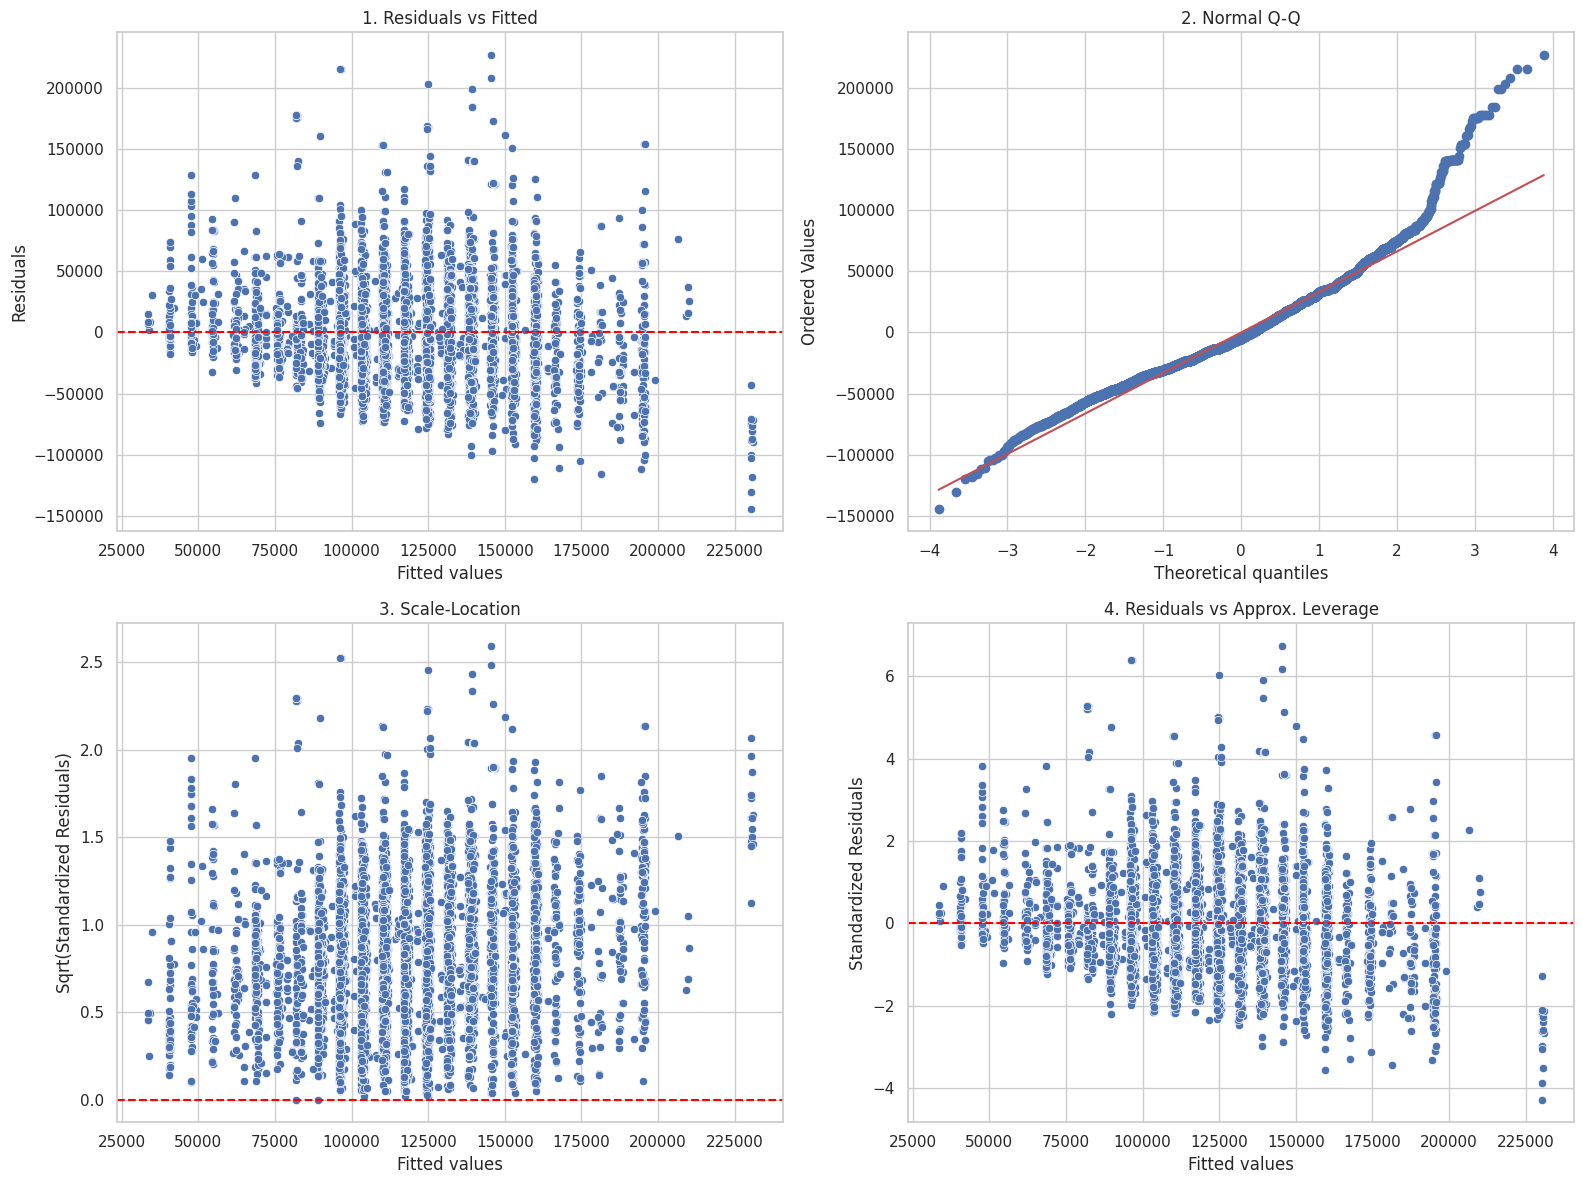

In [6]:
#| eval: true
#| echo: false
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np
import pandas as pd

df_pred = summary.predictions.select("SALARY", "prediction").toPandas()

df_pred["residuals"] = df_pred["SALARY"] - df_pred["prediction"]
df_pred["fitted"] = df_pred["prediction"]

res_mean = df_pred["residuals"].mean()
res_std = df_pred["residuals"].std()
df_pred["std_residuals"] = (df_pred["residuals"] - res_mean) / res_std

df_pred["sqrt_std_resid"] = np.sqrt(np.abs(df_pred["std_residuals"]))

plt.figure(figsize=(16, 12))
sns.set_theme(style="whitegrid")

plt.subplot(2, 2, 1)
sns.scatterplot(x="fitted", y="residuals", data=df_pred)
plt.axhline(0, linestyle="--", color="red")
plt.title("1. Residuals vs Fitted")
plt.xlabel("Fitted values")
plt.ylabel("Residuals")

plt.subplot(2, 2, 2)
stats.probplot(df_pred["residuals"], dist="norm", plot=plt)
plt.title("2. Normal Q-Q")

plt.subplot(2, 2, 3)
sns.scatterplot(x="fitted", y="sqrt_std_resid", data=df_pred)
plt.axhline(0, linestyle="--", color="red")  
plt.title("3. Scale-Location")
plt.xlabel("Fitted values")
plt.ylabel("Sqrt(Standardized Residuals)")

plt.subplot(2, 2, 4)
sns.scatterplot(x="fitted", y="std_residuals", data=df_pred)
plt.axhline(0, linestyle="--", color="red")
plt.title("4. Residuals vs Approx. Leverage")
plt.xlabel("Fitted values")
plt.ylabel("Standardized Residuals")

plt.tight_layout()
plt.savefig("_output/glr_diagnostic_classic.png")
plt.show()

### 1. Residuals vs Fitted
This plot helps evaluate the **linearity** and **homoscedasticity** assumptions of the linear regression model.
- Ideally, residuals should be randomly scattered around the horizontal line at 0.
- In this case, the residuals exhibit a **funnel shape**, indicating **heteroscedasticity**—the variance increases with higher fitted values.
- This suggests that the linear model may not be fully capturing the data pattern and might benefit from transformation or alternative models.

### 2. Normal Q-Q Plot
This plot assesses whether residuals follow a **normal distribution**, which is important for valid statistical inference.
- If residuals are normally distributed, the points will fall along the 45° reference line.
- Here, the ends of the distribution (tails) deviate from the line, indicating **heavy tails** or **non-normality** of residuals.
- This could affect the reliability of p-values and confidence intervals.

### 3. Scale-Location Plot (Spread vs Fitted)
This plot checks for **homoscedasticity** by visualizing the square root of standardized residuals.
- A random scatter suggests constant variance (good).
- The pattern here shows increasing spread as fitted values grow, reinforcing the concern of **non-constant variance**.
- This is another sign that a transformation or alternative modeling strategy might be needed.

### 4. Residuals vs Approx. Leverage
This plot is used to detect **influential observations** that could disproportionately affect the model.
- Most points are centered and within reasonable range, with no clear high-leverage outliers.
- However, some observations have higher standardized residuals, which may require closer examination.

# Evaluation

The evaluation of the model is crucial to understand its performance. In this section, we will calculate and visualize the following metrics:
1. **R² (Coefficient of Determination)**: Indicates how well the model explains the variance in the target variable.
2. **RMSE (Root Mean Squared Error)**: Measures the average magnitude of the errors between predicted and actual values.

In [7]:
#| eval: true
#| echo: false
from pyspark.ml.regression import GeneralizedLinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col, pow, sqrt, avg
import numpy as np

glr = GeneralizedLinearRegression(featuresCol="features", labelCol="SALARY")
glr_model = glr.fit(train_data)
summary = glr_model.summary

pred_glr = glr_model.transform(test_data)

evaluator = RegressionEvaluator(labelCol="SALARY", predictionCol="prediction", metricName="r2")
r2_eval = evaluator.evaluate(pred_glr)
r2 = r2_eval

aic = summary.aic

n = pred_glr.count()
k = len(glr_model.coefficients) + 1  
rss = pred_glr.select(avg(pow(col("SALARY") - col("prediction"), 2))).first()[0] * n
bic = n * np.log(rss / n) + k * np.log(n)

residuals_df = pred_glr.withColumn("squared_error", pow(col("SALARY") - col("prediction"), 2))
rmse = residuals_df.select(sqrt(avg("squared_error"))).first()[0]

print("--- Model Evaluation ---")
print(f"R²: {r2:.4f}")
print(f"AIC: {aic:.4f}")
print(f"BIC: {bic:.4f}")
print(f"RMSE: {rmse:.2f}")

25/04/07 23:24:42 WARN Instrumentation: [6fa398ba] regParam is zero, which might cause numerical instability and overfitting.
[Stage 32:>                                                         (0 + 1) / 1]

--- Model Evaluation ---
R²: 0.3819
AIC: 320843.0903
BIC: 68922.1509
RMSE: 33322.61


Below are the key performance metrics for the Generalized Linear Regression (GLR) model:

- **R² (Coefficient of Determination) = 0.3819**  
  This means that approximately **38.2%** of the variance in the target variable (salary) is explained by the model. While this indicates that the model captures some underlying patterns, there's still significant unexplained variance, suggesting room for improvement.

- **AIC (Akaike Information Criterion) = 320843.09**  
  AIC is used to compare models — **lower AIC indicates a better fit** with fewer parameters. This value on its own is not interpretable, but it becomes useful when comparing this GLR model to alternative models (e.g., Random Forest, Ridge Regression).

- **BIC (Bayesian Information Criterion) = 68922.15**  
  Similar to AIC, BIC penalizes more complex models even more harshly. Like AIC, it is useful when comparing models — again, **lower is better**.

- **RMSE (Root Mean Squared Error) = 33,322.61**  
  This metric shows that on average, the model’s salary predictions deviate from actual values by about **$33K**, which is quite substantial. A lower RMSE would indicate better predictive performance.

The model demonstrates **moderate predictive power**, but:
- The high RMSE suggests **large prediction errors**, especially for higher-salary positions.
- R² indicates that a majority of the salary variation is **not explained** by the current feature set.

## Model Evaluation Plot

- Display the predicted vs actual salary plot with a red line indicating the ideal fit (y=x).
- Use `seaborn` or `matplotlib` to create the plot.
- Customize the plot with appropriate titles, labels, and legends.
- Describe the plot in a few sentences, highlighting key insights and observations.

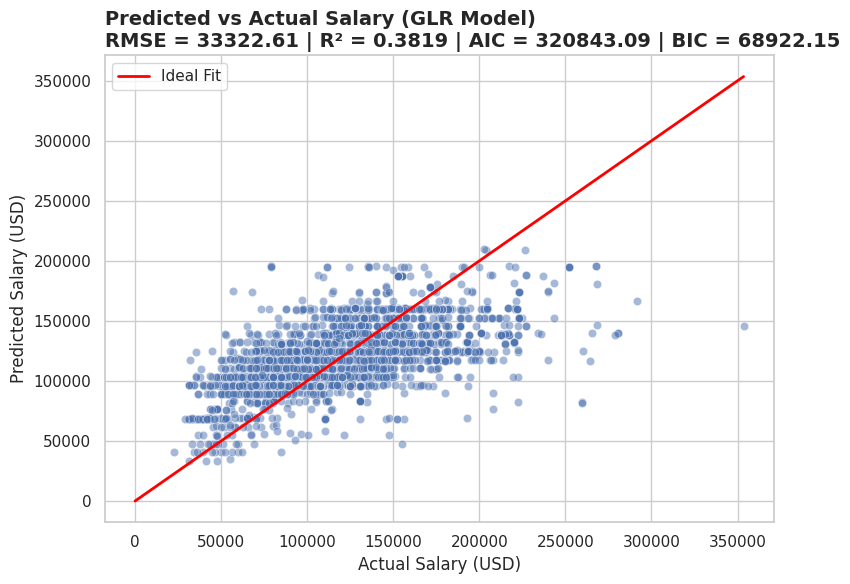

In [8]:
#| eval: true
#| echo: false
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert GLR predictions to pandas
pandas_df = pred_glr.select("SALARY", "prediction").toPandas()

# Plot
plt.figure(figsize=(8, 6))
sns.set_theme(style="whitegrid")

# Scatter plot: predicted vs actual
sns.scatterplot(data=pandas_df, x="SALARY", y="prediction", alpha=0.5)

# Ideal fit line (y = x)
max_val = max(pandas_df["SALARY"].max(), pandas_df["prediction"].max())
plt.plot([0, max_val], [0, max_val], color="red", linestyle="-", linewidth=2, label="Ideal Fit")

# Title with metrics
plt.title(
    f"Predicted vs Actual Salary (GLR Model)\n"
    f"RMSE = {rmse:.2f} | R² = {r2:.4f} | AIC = {aic:.2f} | BIC = {bic:.2f}",
    loc="left", fontsize=14, fontweight="bold"
)

# Axis labels
plt.xlabel("Actual Salary (USD)")
plt.ylabel("Predicted Salary (USD)")
plt.legend()

# Save & show
plt.tight_layout()
plt.savefig("_output/glr_predicted_vs_actual.png", dpi=300)
plt.show()

The scatter plot above visualizes the relationship between the **actual salary values** (x-axis) and the **predicted salary values** (y-axis) produced by the Generalized Linear Regression (GLR) model. The red diagonal line (y = x) represents the ideal scenario where predicted values exactly match the actual ones.

From the plot, we observe the following:

- **Overall Trend**: The model captures a clear upward trend, meaning that higher actual salaries are generally associated with higher predicted values.
- **Deviation from the Ideal Line**: Many data points deviate significantly from the red line, especially at higher salary levels. This suggests that the model is **less accurate** in predicting high salaries.
- **Clustered Distribution**: The majority of the data points are clustered in the \$50,000–\$150,000 salary range, which may indicate data imbalance or concentration in mid-level jobs.
- **Underestimation**: The model tends to **underestimate** high salaries. Several points lie well below the ideal line in the upper right quadrant.
- **Metrics Interpretation**:
  - **R² = 0.3819**: The model explains roughly 38% of the variance in salaries—acceptable but indicates limited predictive power.
  - **RMSE = 33,322.61**: The average prediction error is about \$33K, which is relatively large compared to typical salary scales.
  - **AIC & BIC**: These are used for model comparison. While their absolute values aren’t meaningful on their own, they provide a basis for comparing this model to alternatives.

This model provides a **reasonable starting point** for salary prediction but could be improved by:
- Including more relevant features (e.g., location, years of experience, job level).
- Trying more complex models (e.g., random forest or gradient boosting).
- Addressing data imbalance through sampling or feature engineering.

# Submission {.unnumbered}
1. Save figures in the `_output/` folder.
2. Commit and push code and output files:
```bash
git add .
git commit -m "Add Lab 08 Salary Prediction models and output"
git push origin main
```
3. Submit your GitHub repository link.

# Resources {.unnumbered}
- [PySpark MLlib Docs](https://spark.apache.org/docs/latest/ml-guide.html)  
- [Seaborn Docs](https://seaborn.pydata.org/)  
- [Pandas User Guide](https://pandas.pydata.org/docs/user_guide/index.html)
